<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li></ul></li><li><span><a href="#Read-and-explore-data" data-toc-modified-id="Read-and-explore-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read and explore data</a></span><ul class="toc-item"><li><span><a href="#Split-the-dataset-into-train-and-test-data" data-toc-modified-id="Split-the-dataset-into-train-and-test-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Split the dataset into train and test data</a></span></li><li><span><a href="#Data-transformation" data-toc-modified-id="Data-transformation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data transformation</a></span></li><li><span><a href="#Create-a-3D-Input-Dataset" data-toc-modified-id="Create-a-3D-Input-Dataset-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create a 3D Input Dataset</a></span></li></ul></li><li><span><a href="#Create-BiLSTM,-LSTM-and-GRU-model" data-toc-modified-id="Create-BiLSTM,-LSTM-and-GRU-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create BiLSTM, LSTM and GRU model</a></span><ul class="toc-item"><li><span><a href="#Fit-the-models" data-toc-modified-id="Fit-the-models-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fit the models</a></span><ul class="toc-item"><li><span><a href="#Plot-train-loss-vs-validation-loss" data-toc-modified-id="Plot-train-loss-vs-validation-loss-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Plot train loss vs validation loss</a></span></li></ul></li><li><span><a href="#Inverse-target-variable-for-train-and-test-data" data-toc-modified-id="Inverse-target-variable-for-train-and-test-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Inverse target variable for train and test data</a></span></li></ul></li><li><span><a href="#Make-prediction-using-BiLSTM,-LSTM-and-GRU" data-toc-modified-id="Make-prediction-using-BiLSTM,-LSTM-and-GRU-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Make prediction using BiLSTM, LSTM and GRU</a></span><ul class="toc-item"><li><span><a href="#Plot-true-future-vs-prediction" data-toc-modified-id="Plot-true-future-vs-prediction-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plot true future vs prediction</a></span></li><li><span><a href="#Calculate-RMSE-and-MAE" data-toc-modified-id="Calculate-RMSE-and-MAE-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Calculate RMSE and MAE</a></span></li></ul></li></ul></div>

## Импорт библиотек

In [1]:
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np
from math import sqrt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from plotly.offline import iplot

# Использование cufflinks в офлайн-режиме
import cufflinks
cufflinks.go_offline()

# Настройка глобальной темы cufflinks
cufflinks.set_config_file(world_readable=True, theme='pearl', offline=True)

In [2]:
# Set random seed for reproducibility
numpy.random.seed(1234)
tf.random.set_seed(8)

# Read and explore data 
While I import the data from a CSV file, I make sure the **date** column has the correct *DateTime* format by **parse_dates = ['date']**.

When I work with date and time, it becomes much easier if I set **date** column as the dataframe index.

In [3]:
file = 'data_fact_week_3.csv'
raw_data = pd.read_csv(file, parse_dates = ['date'], index_col = 'date')

df = raw_data.copy()

## Split the dataset into train and test data
In this project, I set the first 80% of data as train data and the remaining 20% as test data. I train the model with train data and validate its performance with test data.

Dimension of train data:  (128, 1)
Dimension of test data:  (32, 1)


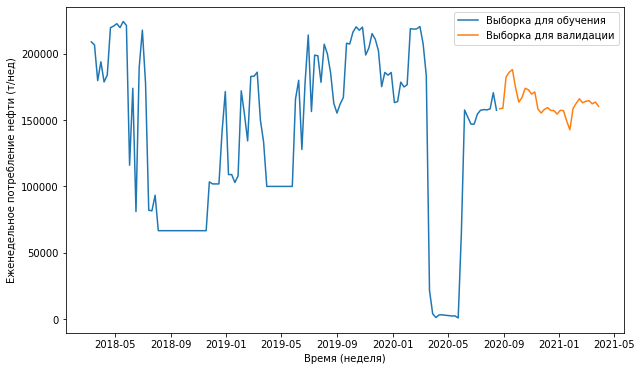

In [4]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.fact)
plt.plot(test_dataset.fact)
plt.xlabel('Время (неделя)')
plt.ylabel('Еженедельное потребление нефти (т/нед)')
plt.legend(['Выборка для обучения', 'Выборка для валидации'], loc='upper right')

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

## Data transformation 
A good rule of thumb is that normalized data lead to better performance in Neural Networks. In this project, I use **MinMaxScaler** from sklearn. 

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_dataset)
test_norm = scaler.fit_transform(test_dataset)
df_norm = scaler.fit_transform(df)

## Create a 3D Input Dataset
LSTM, GRU and BiLSTM take a 3D input (num_samples, num_timesteps, num_features). So, I create a helper function, *create_dataset*, to reshape input.

In this project, I define time_steps = 3. It means that the model makes predictions based on the last 3-month data (In the first iteration of the for-loop, the input carries the first 3 months and the output is 'fact' on the 3d month).

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_steps = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:i+time_steps, :]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return numpy.array(dataX), numpy.array(dataY)

TIME_STEPS = 3

trainX, trainY = create_dataset(train_norm, TIME_STEPS)
testX, testY = create_dataset(test_norm, TIME_STEPS)
X, y = create_dataset(df_norm, TIME_STEPS)
print('trainX.shape: ', trainX.shape)
print('trainY.shape: ', trainY.shape)
print('testX.shape: ', testX.shape) 
print('testY.shape: ', testY.shape)

trainX.shape:  (125, 3, 1)
trainY.shape:  (125, 1)
testX.shape:  (29, 3, 1)
testY.shape:  (29, 1)


In [7]:
df2 = pd.DataFrame(X[:, :, 0])

In [8]:
df2.rename(columns=lambda x: "Week" + str(x + 1), inplace=True)

In [14]:
df2['target'] = y

In [15]:
df2.index = df[3:].index

In [16]:
df2

,Week1,Week2,Week3,consumption
date,,,,
2018-04-01,0.931111,0.920726,0.800402,0.864046
2018-04-08,0.920726,0.800402,0.864046,0.796018
2018-04-15,0.800402,0.864046,0.796018,0.819431
2018-04-22,0.864046,0.796018,0.819431,0.979024
2018-04-29,0.796018,0.819431,0.979024,0.984452
...,...,...,...,...
2021-02-28,0.724282,0.739297,0.725695,0.730837
2021-03-07,0.739297,0.725695,0.730837,0.732885
2021-03-14,0.725695,0.730837,0.732885,0.722336


In [17]:
df2['target'].iplot(kind='hist')

<AxesSubplot:>

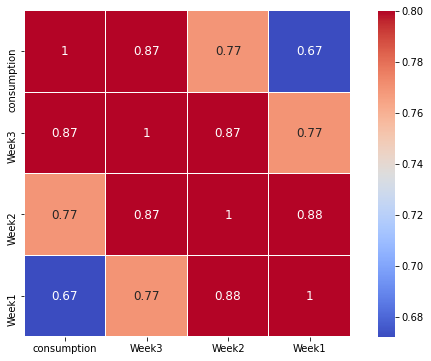

In [18]:
numerical_features = df2.select_dtypes(include=[np.number])
k = 4
correlation = numerical_features.corr(method='spearman')
cols = correlation.nlargest(k, "consumption")["consumption"].index
cm = np.corrcoef(df2[cols].values.T)
fig, axes = plt.subplots(figsize = (10, 6))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="coolwarm",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

# Create BiLSTM, LSTM and GRU model
The first function, create_model_bilstm, creates a BDLSM and gets the number of units (neurons) in hidden layers. The second function, *create_model*, gets two inputs; number of units in hidden layers and model name (LSTM or GRU).

For the sake of simplicity, BiLSTM, LSTM and GRU have 2 hidden layers including 64 neurons and 1 neuron in the output layer.

To make the LSTM and GRU networks robust to changes, the Dropout function is used. Dropout(0.2)  randomly drops 20% of units from the network.

In [14]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(trainX.shape[1], trainX.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model/
    model.compile(loss='mse', optimizer='adam')
    return model

# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [trainX.shape[1], trainX.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# BiLSTM
model_bilstm = create_model_bilstm(64)

# GRU and LSTM 
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

## Fit the models
I train the model with train data for 100 epoch and batch_size = 32. I get the model to use 20% of train data as validation data. It is important to set shuffle = False because the order of the data matters in our project.

To avoid overfitting, I set an early stop to stop training when "val_loss" has not improved after 10 epochs (patience = 10).


In [15]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(trainX, trainY, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop], verbose=0)
    return history

history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

### Plot train loss vs validation loss 

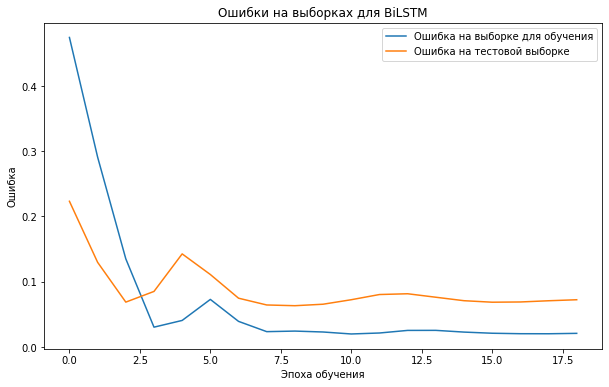

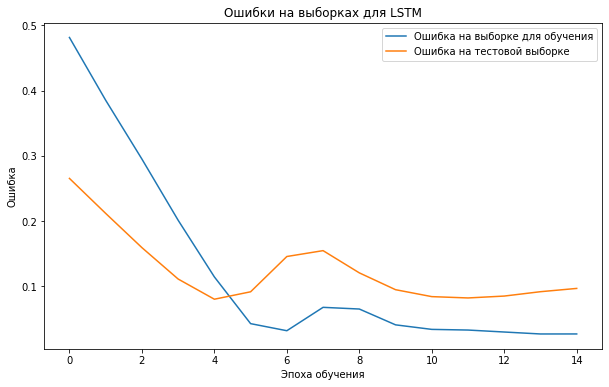

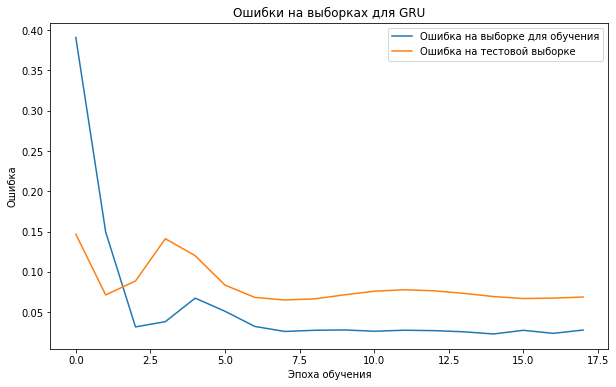

In [16]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Ошибки на выборках для ' + model_name)
    plt.ylabel('Ошибка')
    plt.xlabel('Эпоха обучения')
    plt.legend(['Ошибка на выборке для обучения', 'Ошибка на тестовой выборке'], loc='upper right')

plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

## Inverse target variable for train and test data
After building the model, I have to transform the target variable back to original data space for train and test data using scaler.inverse_transform.

In [17]:
# Note that I have to use scaler
testY = scaler.inverse_transform(testY)
trainY = scaler.inverse_transform(trainY)

# Make prediction using BiLSTM, LSTM and GRU
Here I predict 'fact' using BiLSTM, LSTM and GRU models. Then, I plot true future vs prediction the three models.

In [18]:
def prediction(model):
    prediction = model.predict(testX)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

## Plot true future vs prediction

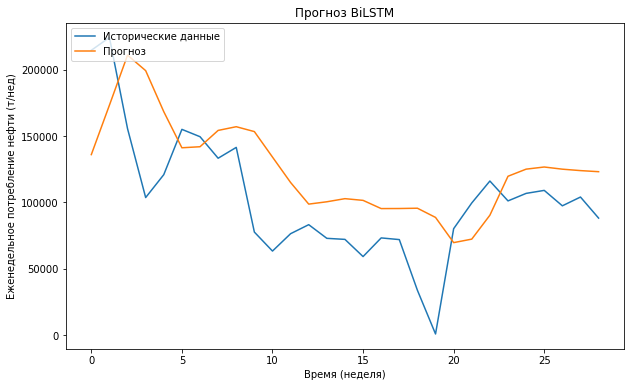

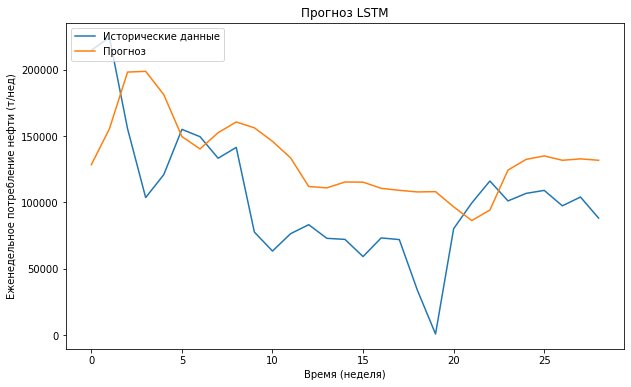

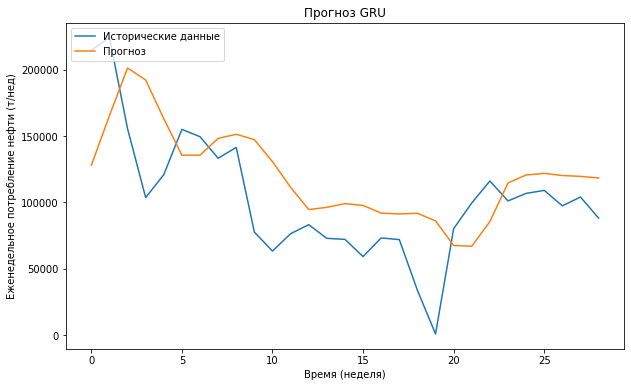

In [19]:
def plot_future(prediction, model_name, testY):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(testY), label='Исторические данные')
    plt.plot(np.arange(range_future), np.array(prediction),label='Прогноз')

    plt.title('Прогноз ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Время (неделя)')
    plt.ylabel('Еженедельное потребление нефти (т/нед)')    
    plt.savefig(f'Прогноз для ({model_name})')
    
plot_future(prediction_bilstm, 'BiLSTM', testY)
plot_future(prediction_lstm, 'LSTM', testY)
plot_future(prediction_gru, 'GRU', testY)

## Calculate RMSE and MAE

In [20]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_bilstm, testY, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, testY, 'LSTM')
evaluate_prediction(prediction_gru, testY, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 37349.2381
Root Mean Square Error: 44580.6491

LSTM:
Mean Absolute Error: 44131.1235
Root Mean Square Error: 51723.0854

GRU:
Mean Absolute Error: 35123.7637
Root Mean Square Error: 42687.8681



Results show that the **GRU** has the best performance compared to LSTM and Bidirectional LSTM. So I use GRU model to forecast oil consumption for the next day. 